In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json
import pandas as pd
import torch.nn.functional as F
import hashlib

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
path_dir_sc_bn = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230622_154449"
path_dir_harcoded_bn = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230627_150517"
path_dir_set5 = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230628_131036"
path_hardcoded_new_optim = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230628_151930"
path_hardcoded_new_optim_corr_shape = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230629_150333"
path_feedformer = "work_dirs/feedformer.b0.512x512.ade.160k_julian/20230703_151459"
# path_file = "model_init_2.pth"

In [3]:
# state_dict = torch.load(path_file)#["state_dict"]
# alphas_init = [state_dict[e] for e in state_dict if "alpha" in e][0]
# lambdas_init = nn.Sigmoid()(alphas_init)

In [9]:
def plot_results(path_dir):
    filenames = [filename for filename in os.listdir(path_dir) if filename.endswith("pth")]
    numbers = []
    for string in filenames:
        match = re.search(r'\d+', string)  # Extracts the first occurrence of one or more digits
        if match:
            number = int(match.group())  # Converts the matched string to an integer
            numbers.append(number)
    filenames = [tup[0] for tup in sorted(zip(filenames, numbers), key=lambda x:x[1])]

    alphas, lambdas = [], []

    for file in filenames:
        path_file = os.path.join(path_dir, file)
        try:
            state_dict = torch.load(path_file)["state_dict"]
        except:
            state_dict = torch.load(path_file)
        alpha_tens = [state_dict[e] for e in state_dict if "alpha" in e][0].to(torch.device("cpu"))
        lambda_tens = nn.Sigmoid()(alpha_tens)
        alphas.append(alpha_tens)
        lambdas.append(lambda_tens)

    alphas_torch = torch.concat(alphas)
    lambdas_torch = torch.concat(lambdas)

    numb_alpha_convergences = 10
    plt.title(f"{numb_alpha_convergences} randomly picked lambda convergences")
    for i in range(numb_alpha_convergences):
        idx_rand = np.random.randint(lambdas_torch.shape[-1])
        plt.plot(sorted(numbers), lambdas_torch[:, idx_rand, idx_rand], label=f"Idx: {idx_rand}")
        plt.ylim(0, 1)
        plt.ylabel("lambda")
        plt.xlabel("Iteration")
    
    return lambdas_torch

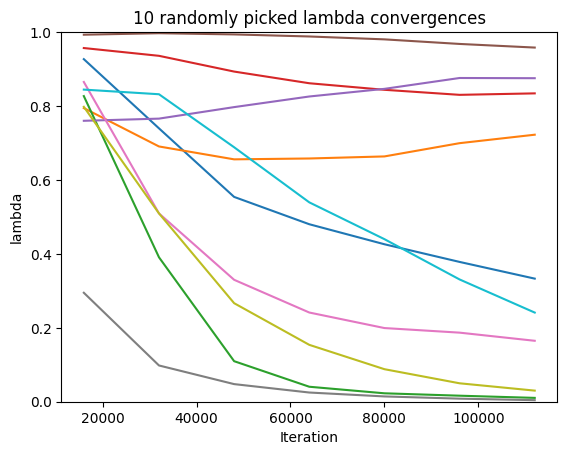

In [17]:
lambdas_torch = plot_results(path_dir_set5)

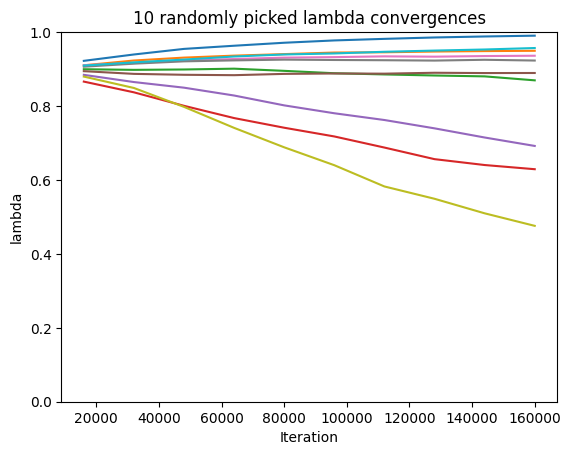

In [28]:
torch_lambdas = plot_results(path_hardcoded_new_optim)

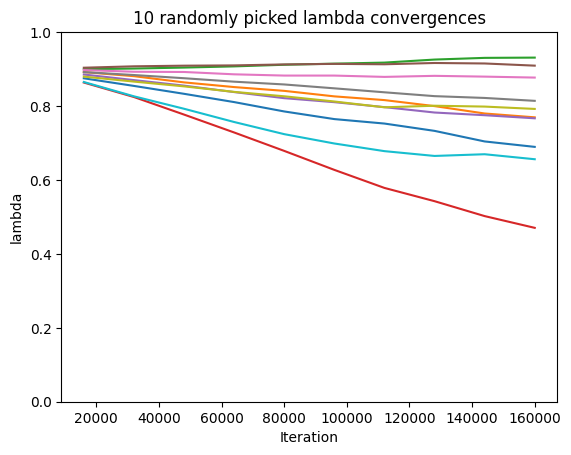

In [88]:
torch_lambdas2 = plot_results(path_hardcoded_new_optim_corr_shape)

In [125]:
from PIL import Image
from io import BytesIO
def create_lambdas_changing_gif(torch_lambdas):
        # Assuming `torch_lambdas` is a list of torch tensors
    # torch_lambdas = [...]

    # Create a list to store individual plot images
    plot_images = []

    # Generate plot images for each matrix
    for i, tensor in enumerate(torch_lambdas):
        plt.imshow(tensor, vmin=0, vmax=1)
        plt.colorbar()
        plt.title(f"Lambdas at iteration {16000 * (i + 1)}")
        plt.xlabel("embed_dim")
        plt.ylabel("token_dim")

        
        # Store the plot image in memory
        image_buffer = BytesIO()
        plt.savefig(image_buffer, format='png')
        image_buffer.seek(0)
        
        # Open the image from memory
        plot_image = Image.open(image_buffer)
        
        # Add the image to the list
        plot_images.append(plot_image)
        
        # Clear the plot for the next iteration
        plt.clf()

    # Save the list of images as a GIF
    plot_images[0].save("torch_lambdas.gif",
                        save_all=True,
                        append_images=plot_images[1:],
                        duration=500,
                        loop=0)

    # Clean up the image buffers
    for image_buffer in plot_images:
        image_buffer.close()

In [126]:
create_lambdas_changing_gif(torch_lambdas2)

<Figure size 640x480 with 0 Axes>

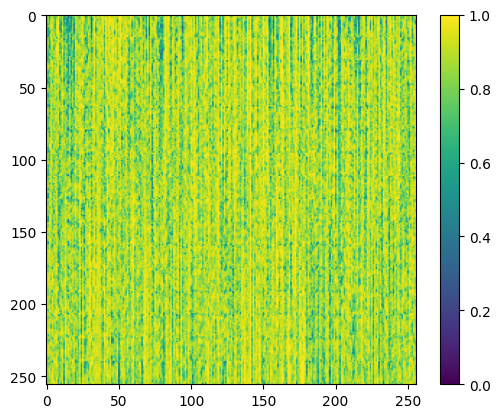

In [81]:
plt.imshow(torch_lambdas2[-1], vmin=0, vmax=1)
plt.colorbar()

Text(0.5, 1.0, 'Histogram of final lambda values at iter 160000')

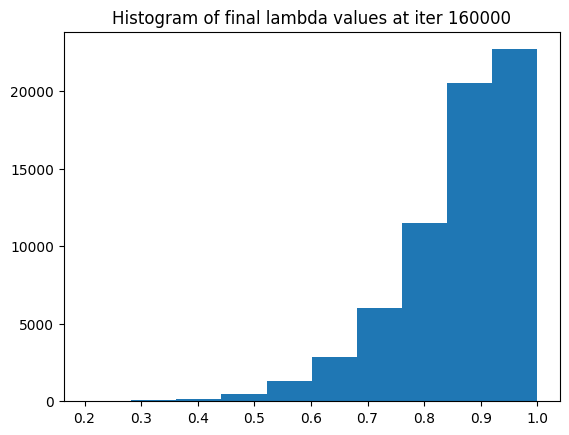

In [128]:
plt.hist(torch_lambdas2[-1].flatten())
plt.title("Histogram of final lambda values at iter 160000")

In [97]:
torch_lambdas2[-1] < 0.5

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [96]:
lambdas_torch[-1].shape

torch.Size([224, 224])

(array([ 2.,  9., 18., 27., 40., 52., 47., 45., 14.,  2.]),
 array([0.70691609, 0.73461282, 0.76230955, 0.79000634, 0.81770307,
        0.8453998 , 0.87309653, 0.90079325, 0.92849004, 0.95618677,
        0.9838835 ]),
 <BarContainer object of 10 artists>)

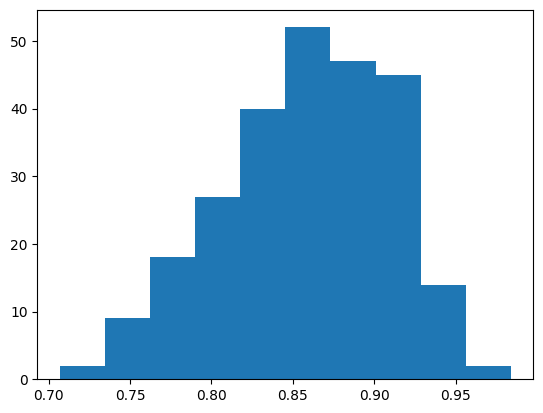

In [98]:
plt.hist(torch_lambdas2[-1].mean(0))

Text(0.5, 1.0, 'Boxplot of final lambda values at iter 160000')

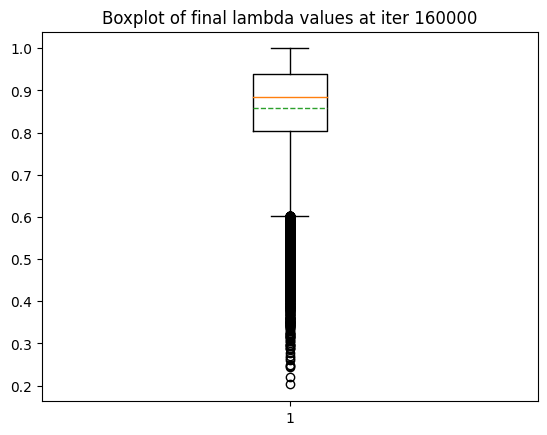

In [129]:
plt.boxplot(torch_lambdas2[-1].flatten(), showmeans=True, meanline=True)
plt.title("Boxplot of final lambda values at iter 160000")

In [119]:
torch_lambdas2[-1][0]

tensor([0.5040, 0.8938, 0.7606, 0.9377, 0.9829, 0.8514, 0.9524, 0.9500, 0.9694,
        0.8724, 0.9565, 0.9660, 0.7792, 0.9635, 0.9722, 0.9284, 0.8763, 0.6084,
        0.7113, 0.9483, 0.9706, 0.8805, 0.9791, 0.6645, 0.9897, 0.9257, 0.6057,
        0.7094, 0.5942, 0.9306, 0.9658, 0.4171, 0.7021, 0.9943, 0.9515, 0.7870,
        0.9760, 0.9401, 0.9783, 0.8188, 0.9406, 0.9878, 0.8263, 0.6408, 0.9700,
        0.9166, 0.9026, 0.7236, 0.8794, 0.6111, 0.9069, 0.9741, 0.9827, 0.8506,
        0.9791, 0.9752, 0.8797, 0.9623, 0.9625, 0.9082, 0.7004, 0.5796, 0.8389,
        0.8857, 0.9173, 0.8937, 0.9109, 0.9015, 0.9647, 0.6912, 0.9641, 0.6675,
        0.8865, 0.9324, 0.9055, 0.9892, 0.9747, 0.6605, 0.5132, 0.9453, 0.7271,
        0.8756, 0.9935, 0.7362, 0.9564, 0.9131, 0.4068, 0.9927, 0.9466, 0.8948,
        0.8380, 0.8249, 0.9874, 0.6534, 0.5548, 0.9727, 0.9238, 0.9892, 0.9087,
        0.7939, 0.8361, 0.7987, 0.9639, 0.7604, 0.8428, 0.4102, 0.4476, 0.9111,
        0.6802, 0.6326, 0.9559, 0.9755, 

Text(0.5, 1.0, 'Each boxplot represents one token (10 tokens dims in total)')

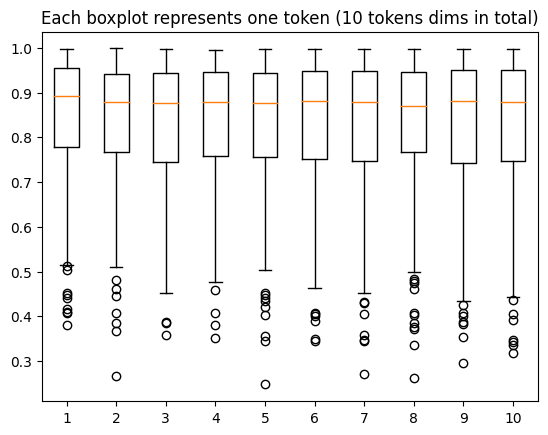

In [124]:
plt.boxplot(torch_lambdas2[-1][0:10])
plt.title("Each boxplot represents one token (10 tokens dims in total)")

(array([ 1.,  6., 10., 18., 37., 42., 54., 57., 27.,  4.]),
 array([0.71204853, 0.73975003, 0.76745158, 0.79515314, 0.82285464,
        0.85055614, 0.87825769, 0.90595925, 0.93366075, 0.96136224,
        0.9890638 ]),
 <BarContainer object of 10 artists>)

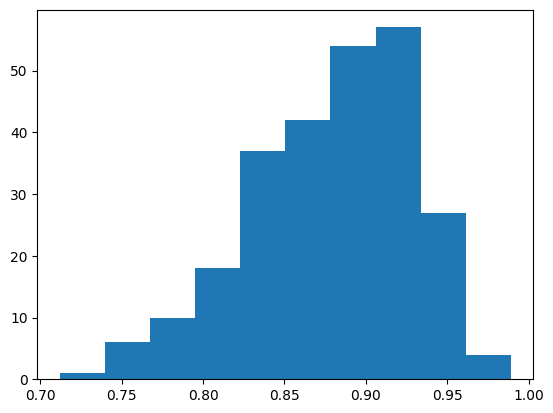

In [103]:
plt.hist(torch_lambdas2[-1].median(0)[0])

(array([10948.,  3858.,  3043.,  2876.,  2771.,  2768.,  2994.,  3506.,
         4577., 12835.]),
 array([6.37351505e-09, 1.00000009e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

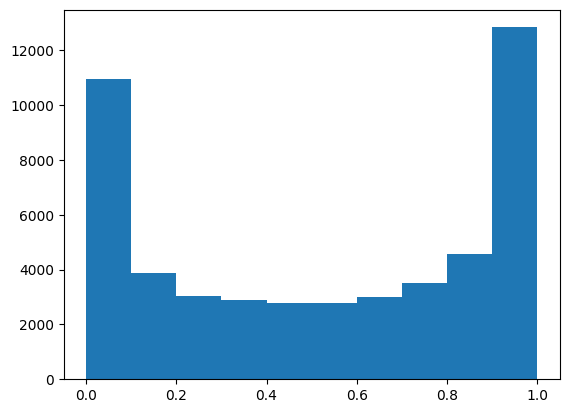

In [15]:
plt.hist(lambdas_torch[-1].flatten())

In [73]:
lambd_resized = F.interpolate(torch_lambdas[-1].unsqueeze(0).unsqueeze(0), (256, 256))
lambd_resized = lambd_resized.squeeze(0).squeeze(0)
lambd_resized[0].reshape(16, 16).min()

tensor(0.2533)

In [74]:
lambd_resized[0].reshape(16, 16).max()

tensor(0.9995)

In [59]:
torch_lambdas[-1]

tensor([[0.4758, 0.8666, 0.7272,  ..., 0.8270, 0.7496, 0.9759],
        [0.5043, 0.8248, 0.6229,  ..., 0.7265, 0.7343, 0.9312],
        [0.5587, 0.7953, 0.5993,  ..., 0.6574, 0.6858, 0.8398],
        ...,
        [0.7672, 0.7651, 0.7931,  ..., 0.8689, 0.9580, 0.9136],
        [0.7526, 0.7776, 0.8049,  ..., 0.9055, 0.9151, 0.8813],
        [0.6639, 0.8597, 0.8574,  ..., 0.9662, 0.8897, 0.8465]])

In [50]:
def get_params_all_stages(path_dir):
    filenames = [filename for filename in os.listdir(path_dir) if filename.endswith("pth")]
    numbers = []
    for string in filenames:
        match = re.search(r'\d+', string)  # Extracts the first occurrence of one or more digits
        if match:
            number = int(match.group())  # Converts the matched string to an integer
            numbers.append(number)
    filenames = [tup[0] for tup in sorted(zip(filenames, numbers), key=lambda x:x[1])]

    try:
        state_dict = torch.load(os.path.join(path_dir, filenames[0]))["state_dict"]
    except:
        state_dict = torch.load(path_dir, filenames[0])
    num_parameters = len([state_dict[e].shape for e in state_dict if "alpha" in e])

    alphas = [[] for _ in range(num_parameters)]
    lambdas = [[] for _ in range(num_parameters)]
    for file in filenames:
        path_file = os.path.join(path_dir, file)
        try:
            state_dict = torch.load(path_file)["state_dict"]
        except:
            state_dict = torch.load(path_file)
        
        alpha_tens = [state_dict[e].to(torch.device("cpu")) for e in state_dict if "alpha" in e]
        
        for i in range(num_parameters):
            alphas[i].append(alpha_tens[i])
            lambdas[i].append(nn.Sigmoid()(alpha_tens[i]))

    # alphas_torch = torch.concat(alphas)
    # lambdas_torch = torch.concat(lambdas)

    # numb_alpha_convergences = 10
    # plt.title(f"{numb_alpha_convergences} randomly picked lambda convergences")
    # for i in range(numb_alpha_convergences):
    #     idx_rand = np.random.randint(lambdas_torch.shape[-1])
    #     plt.plot(sorted(numbers), lambdas_torch[:, idx_rand, idx_rand], label=f"Idx: {idx_rand}")
    #     plt.ylim(0, 1)
    #     plt.ylabel("lambda")
    #     plt.xlabel("Iteration")
    
    return alphas, lambdas

In [51]:
alphas, lambdas = get_params_all_stages(path_feedformer)

In [95]:
def plot_results(style="plot", y_lim=None):
    """
    Args:
        style : string
            style in "plot", "hist", "box"
    """
    x = y = int(len(lambdas) ** 0.5)
    fig, axs = plt.subplots(x, y, figsize=(8, 7))
    for i in range(len(lambdas)):
        row, col = int(i / x),  i  % x
        params = torch.cat(lambdas[i])
        if style == "plot":
            x_vals = [(i + 1) * 16000 for i in range(len(params))]
            axs[row][col].plot(x_vals, params)
            axs[row][col].set_title(f"Stage {i + 1} with num params: {len(params[0])}")
            axs[row][col].set_xticks
            axs[row][col].set_ylim(y_lim)
        if style == "hist":
            axs[row][col].hist(params[-1].flatten())
            axs[row][col].set_title(f"Stage {i + 1} with num params: {len(params[0])}")
        # axs[row][col].set_ylim((0, 1))
        if style == "box":
            axs[row][col].boxplot(params[-1], showmeans=True, meanline=True)
            axs[row][col].set_title(f"Stage {i + 1} with num params: {len(params[0])}")
            axs[row][col].set_ylim(y_lim)


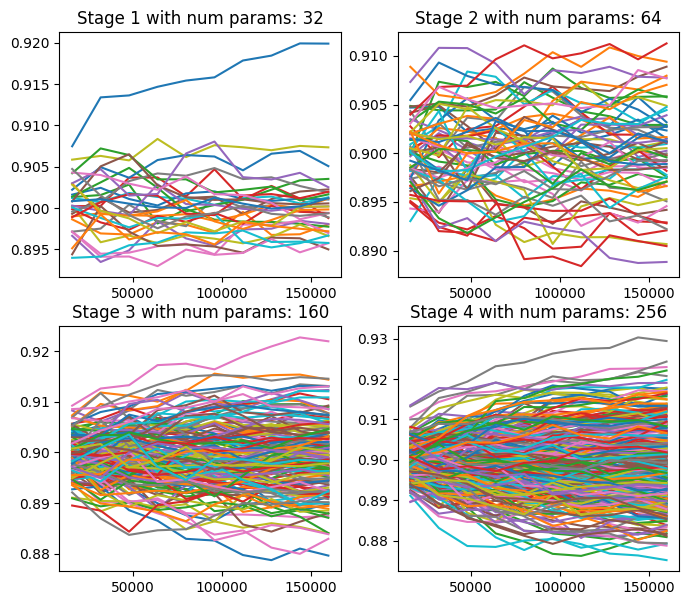

In [96]:
plot_results(style="plot")

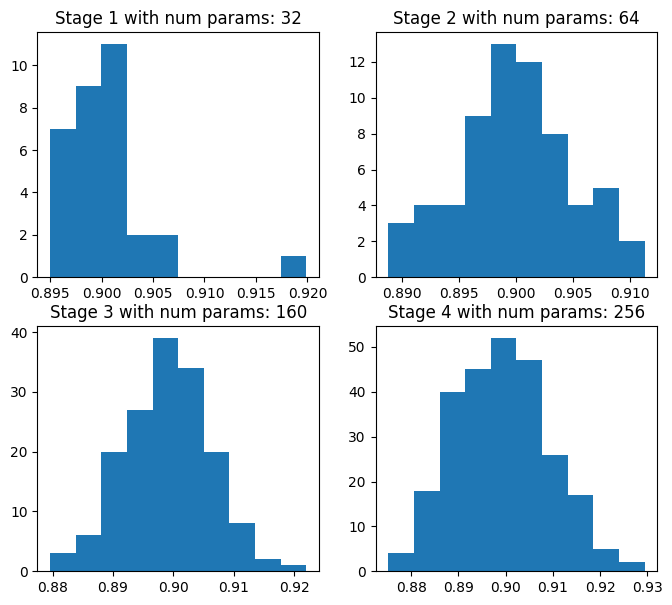

In [97]:
plot_results(style="hist")

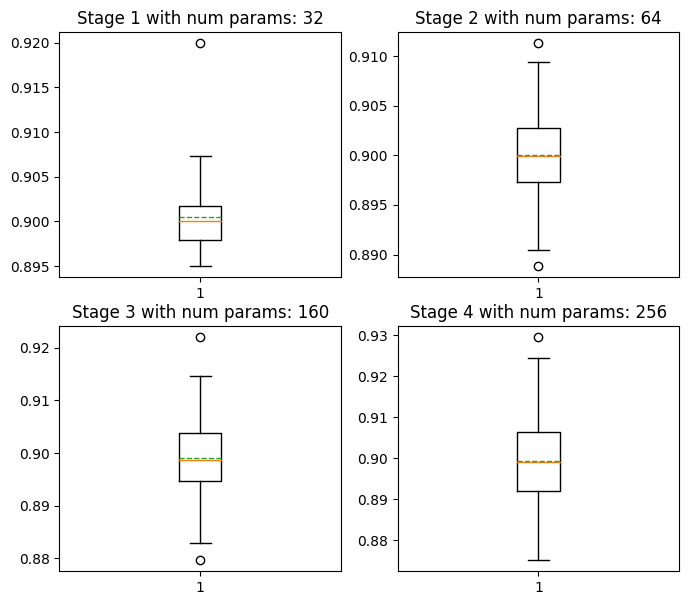

In [98]:
plot_results(style="box")

In [27]:
path_feed_loss = "20230630_181420_seulki_feedformer.json"
path_munet_loss = "SeulKiUNet_20230713_154638.json"
path_munet_loss = "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230713_130415/vis_data/20230713_130415.json"
# path_munet_loss = "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230712_170711/vis_data/20230712_170711.json"
"work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230719_124410/vis_data/20230719_124410.json"

In [28]:
df_loss_munet = pd.read_json(path_munet_loss, lines=True)
df_loss_feed = pd.read_json(path_feed_loss, lines=True)

Text(0, 0.5, 'Loss')

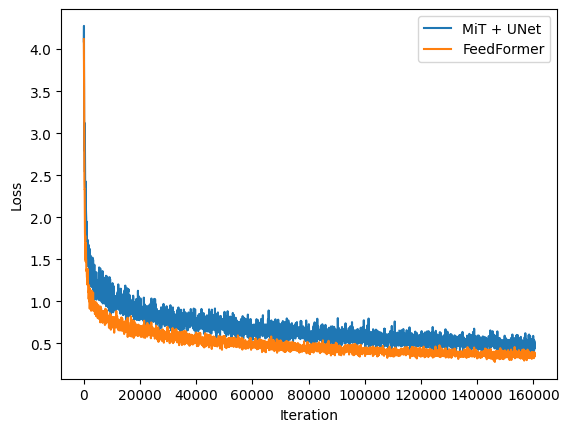

In [29]:
plt.plot([50 * (i+1) for i in range(len(df_loss_munet))], df_loss_munet["loss"], label="MiT + UNet")
# plt.plot([50 * (i+1) for i in range(len(df_loss_munet))], df_loss_feed["loss"].head(len(df_loss_munet)), label="FeedFormer")
plt.plot([50 * (i+1) for i in range(len(df_loss_feed))], df_loss_feed["loss"], label="FeedFormer")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [3]:
def plot_loss_mIoU(paths, names, colors_=None):
    # Create a figure and axes
    fig, ax1 = plt.subplots()

    dfs = [pd.read_json(path, lines=True) for path in paths]
    colors = []
    # colormap='viridis'
    colormap='gist_ncar' # 'gist_rainbow'
    for path in paths:
        hash_object = hashlib.sha256(path.encode())
        hex_value = hash_object.hexdigest()
        numeric_value = int(hex_value, 16)
        cmap = plt.get_cmap(colormap)
        normalized_value = (numeric_value % 1000000) / 1000000.0
        print(normalized_value)
        color = cmap(normalized_value)
        print(color)
        colors.append(color)
    
    if colors_:
        colors = colors_    

    lines = []
    
    for df, name, color in zip(dfs, names, colors):
        # Plot the first column on the left y-axis (ax1)
        line, = ax1.plot([50 * (i+1) for i in range(len(df))], df["loss"], color=color,label=name) #  marker='o'
        lines.append(line)

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('loss', ) #color='b'
    ax1.tick_params(axis='y', )#labelcolor='b'
    ax1.legend()
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc='upper left')

    # Create a second y-axis on the right
    ax2 = ax1.twinx()
    for df, name, color in zip(dfs, names, colors):
    # Plot the second column on the right y-axis (ax2)
        ax2.plot([16000 * (i+1) for i in range(len(df["mIoU"][~df["mIoU"].isna()]))], df["mIoU"][~df["mIoU"].isna()], color=color, marker='s')
    ax2.set_ylabel('mIoU (sqaures)', ) #color='r'
    ax2.tick_params(axis='y', ) #labelcolor='r'

    # Set plot title and show the plot
    plt.title('Training loss vs. validation mIoU')
    plt.legend()
    plt.show()
    return dfs

In [133]:
dfs[1]["mIoU"][dfs[1]["mIoU"].notna()]

320     32.99
641     35.02
962     35.36
1283    35.68
1604    35.56
1925    36.08
2246    36.14
2567    36.26
2888    36.78
3209    36.71
Name: mIoU, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.616396
(1.0, 0.7679547983856564, 0.03798463667820075, 1.0)
0.085366
(0.0, 0.15963962284367297, 0.5435759503801522, 1.0)


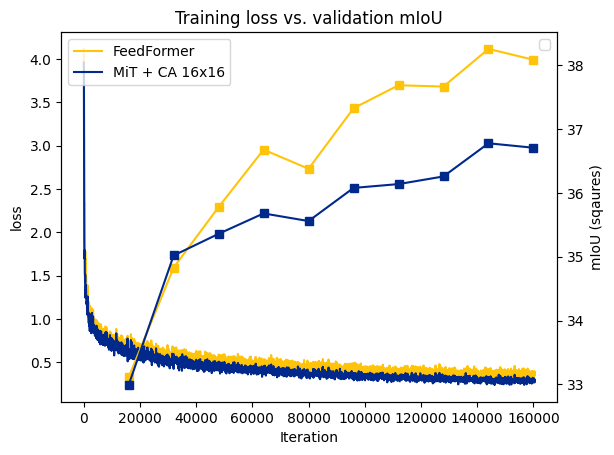

In [132]:
# Idea 1 (with concat)
dfs = plot_loss_mIoU(
    [
    "20230630_181420_seulki_feedformer.json",
    "SeulKiUNet_20230713_154638.json", 
    ],
    [   
        "FeedFormer",
        "MiT + CA 16x16"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.616396
(1.0, 0.7679547983856564, 0.03798463667820075, 1.0)
0.51771
(0.9287634361941493, 1.0, 0.06234555822328974, 1.0)


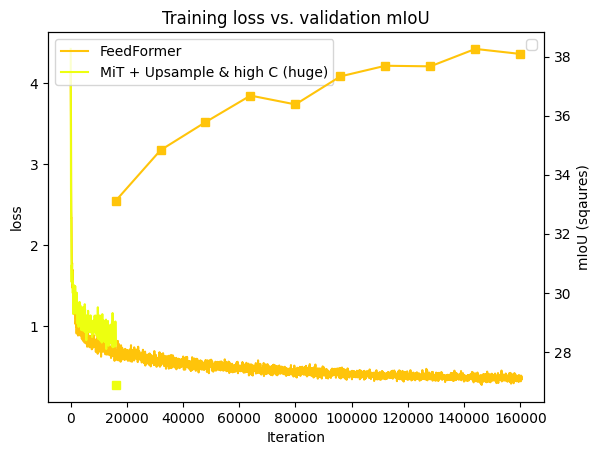

In [129]:
# Idea 2
dfs = plot_loss_mIoU(
    [
    "20230630_181420_seulki_feedformer.json",
    "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230712_170711/vis_data/20230712_170711.json", 
    ],
    [   
        "FeedFormer",
        "MiT + Upsample & high C (huge)"])

In [130]:
dfs[1]["mIoU"][dfs[1]["mIoU"].notna()]

320    26.88
Name: mIoU, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.616396
(1.0, 0.7679547983856564, 0.03798463667820075, 1.0)
0.887231
(0.8772437497592356, 0.45384456587735256, 0.9434675488410301, 1.0)


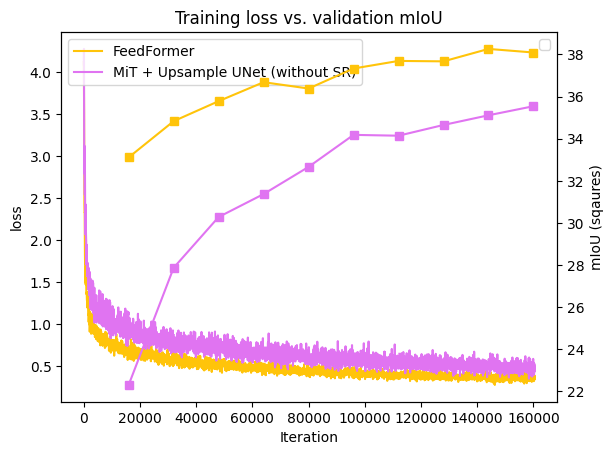

In [125]:
# Idea 3
dfs = plot_loss_mIoU(
    [
    "20230630_181420_seulki_feedformer.json",
    "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230713_130415/vis_data/20230713_130415.json", 
    # "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230719_124410/vis_data/20230719_124410.json"
    ],
    [   
        "FeedFormer",
        "MiT + Upsample UNet (without SR)",
        "MiT + Upsample UNet (with SR)"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.887231
(0.8772437497592356, 0.45384456587735256, 0.9434675488410301, 1.0)
0.015472
(0.0, 0.08585928489042677, 0.3913194925028835, 1.0)


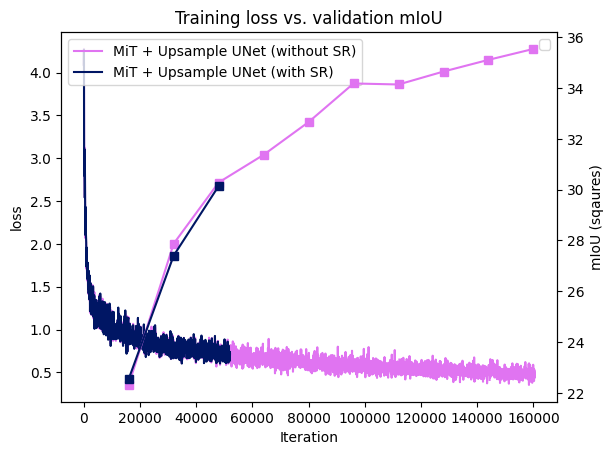

In [112]:
# Idea 4.1
dfs = plot_loss_mIoU(
    [
    #"20230630_181420_seulki_feedformer.json",
    "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230713_130415/vis_data/20230713_130415.json", 
    "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230719_124410/vis_data/20230719_124410.json"
    ],
    [   
        # "FeedFormer",
        "MiT + Upsample UNet (without SR)",
        "MiT + Upsample UNet (with SR)"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.616396
(1.0, 0.7679547983856564, 0.03798463667820075, 1.0)
0.887231
(0.8772437497592356, 0.45384456587735256, 0.9434675488410301, 1.0)
0.431849
(0.5361279849280333, 1.0, 0.06242365612911833, 1.0)


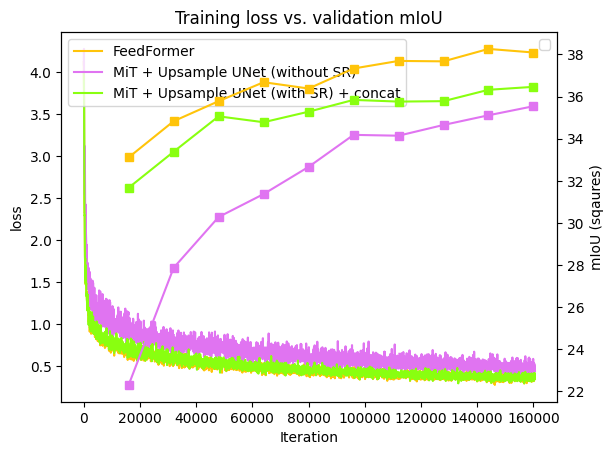

In [117]:
# Idea 4.2
dfs = plot_loss_mIoU(
    [
    "20230630_181420_seulki_feedformer.json",
    "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230713_130415/vis_data/20230713_130415.json", 
    "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230719_161146/vis_data/20230719_161146.json"
    ],
    [   
        "FeedFormer",
        "MiT + Upsample UNet (without SR)",
        "MiT + Upsample UNet (with SR) + concat"])

In [124]:
dfs[1]["mIoU"][dfs[1]["mIoU"].notna()]

320     31.67
641     33.38
962     35.06
1283    34.78
1604    35.28
1925    35.84
2246    35.76
2567    35.78
2888    36.32
3209    36.46
Name: mIoU, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.616396
(1.0, 0.7679547983856564, 0.03798463667820075, 1.0)
0.431849
(0.5361279849280333, 1.0, 0.06242365612911833, 1.0)
0.359811
(0.32468957688338496, 0.8375084352172242, 0.0, 1.0)


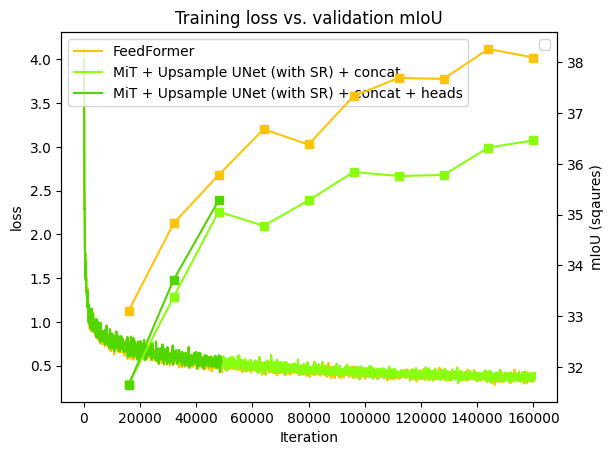

In [122]:
# Idea 4.3
dfs = plot_loss_mIoU(
    [
        "20230630_181420_seulki_feedformer.json",
        # "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230713_130415/vis_data/20230713_130415.json", 
        "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230719_161146/vis_data/20230719_161146.json",
        "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230720_095106/vis_data/20230720_095106.json"
    ],
    [   
        "FeedFormer",
        # "MiT + Upsample UNet (without SR)",
        "MiT + Upsample UNet (with SR) + concat",
        "MiT + Upsample UNet (with SR) + concat + heads"
    ],
    # ["r", "g"]
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.616396
(1.0, 0.7679547983856564, 0.03798463667820075, 1.0)
0.650289
(1.0, 0.5688476445587339, 0.03661830732292912, 1.0)
0.085366
(0.0, 0.15963962284367297, 0.5435759503801522, 1.0)


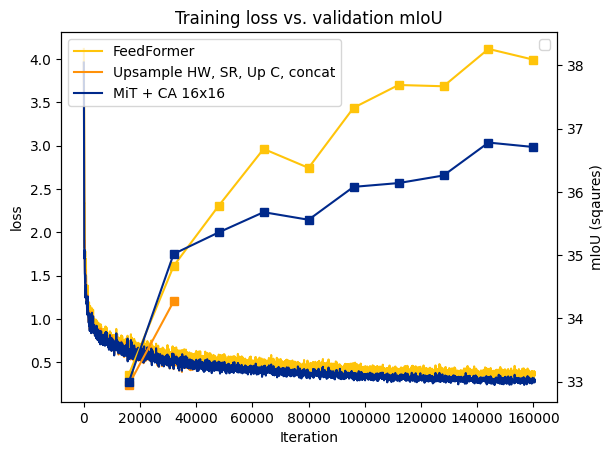

In [4]:
# Idea 4.4
dfs = plot_loss_mIoU(
    [
        "20230630_181420_seulki_feedformer.json",
        # "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230713_130415/vis_data/20230713_130415.json", 
        # "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230719_161146/vis_data/20230719_161146.json",
        # "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230720_095106/vis_data/20230720_095106.json",
        "work_dirs/mitcaunet_mit-b0_8xb2-160k_ade20k-512x512/20230721_100809/vis_data/20230721_100809.json",
        "SeulKiUNet_20230713_154638.json"
    ],
    [   
        "FeedFormer",
        # "MiT + Upsample UNet (without SR)",
        # "Upsample (with SR) + concat",
        # "Upsample (with SR) + concat + heads",
        "Upsample HW, SR, Up C, concat",
        "MiT + CA 16x16"
    ],
    # ["r", "g"]
    )

In [5]:
dfs[1]["mIoU"][dfs[1]["mIoU"].notna()]

320    32.95
641    34.27
Name: mIoU, dtype: float64